Using TensorFlow backend.


(50000, 28, 28) (50000,)


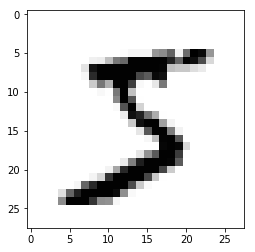

In [1]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [2]:
print(X_train.shape)
print(y_train.shape)

(50000, 28, 28)
(50000,)


## Tensorflow

In [17]:
import tensorflow as tf
import numpy as np
import math
from tensorflow.python.framework import ops
s = tf.InteractiveSession()

In [4]:
X_train_flatten = X_train.reshape(X_train.shape[0], -1).T
X_val_flatten = X_val.reshape(X_val.shape[0], -1).T
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T
print(X_train_flatten.shape)
print(y_train.shape)
print(y_train[1])

(784, 50000)
(50000,)
0


In [5]:
def one_hot_matrix(labels, C):
    C = tf.constant(C, name='C')
    one_hot_matrix = tf.one_hot(indices=labels, depth=C, axis=0)
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
    return one_hot

In [6]:
y_train_one_hot = one_hot_matrix(y_train, C=10)
y_val_one_hot = one_hot_matrix(y_val, C=10)
y_test_one_hot = one_hot_matrix(y_test, C=10)
print(y_train_one_hot.shape)
print(str(y_train_one_hot))

(10, 50000)
[[ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [7]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    return X, Y

In [8]:
def initialize_parameters():
    W1 = tf.get_variable("W1", [100, 784], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [100, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [20, 100], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [20, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [10, 20], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [10, 1], initializer = tf.zeros_initializer())
    
    parameters = {"W1":W1,
                 "b1":b1,
                 "W2":W2,
                 "b2":b2,
                 "W3":W3,
                 "b3":b3}
    return parameters

In [9]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    
    return Z3

In [10]:
tf.reset_default_graph()
with tf.Session() as sess:
    X, Y = create_placeholders(784, 10)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print(str(Z3))

Tensor("Add_2:0", shape=(10, ?), dtype=float32)


In [11]:
def compute_cost(Z3, Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    return cost

In [12]:
tf.reset_default_graph()
with tf.Session() as sess:
    X, Y = create_placeholders(784, 10)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print(str(cost))

Tensor("Mean:0", shape=(), dtype=float32)


In [18]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]
    
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

In [34]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
         num_epochs = 500, minibatch_size = 64, print_cost = True):
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    costs = []
    
    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0.
            num_minibatches = int(m/minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches
            
            if print_cost == True and epoch%100 == 0:
                print("Cost after epoch {}: {}".format(epoch, epoch_cost))
            if print_cost == True and epoch%10 == 0:
                costs.append(epoch_cost)
            
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title('Learning rate = {}'.format(learning_rate))
        plt.show()
        
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print("Train Accuracy: {}".format(accuracy.eval({X: X_train, Y: Y_train})))
        print("Test Accuracy: {}".format(accuracy.eval({X: X_test, Y: Y_test})))
        
        return parameters

Cost after epoch 0: 1.0361870324642195
Cost after epoch 100: 0.00264833836010809
Cost after epoch 200: 4.750240558435682e-05
Cost after epoch 300: 5.674832440182552e-07
Cost after epoch 400: 1.5741784348557987e-07


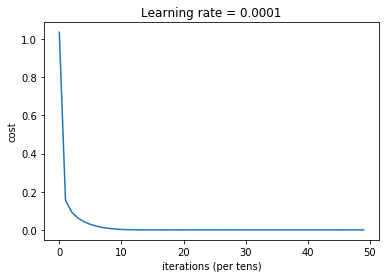

Train Accuracy: 1.0
Test Accuracy: 0.9750999808311462


In [35]:
parameters = model(X_train_flatten, y_train_one_hot, X_test_flatten, y_test_one_hot)

## Keras